In [1]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import axes3d
import scipy.linalg as ln

In [2]:
import functions as func

In [3]:
from optim import Optimizer

from LibOptim import direction_gradient, direction_newton
from LibOptim import fixed_step, wolf_step


In [4]:
def plot_step(F, x_list):
    x_array = np.array(x_list)
    x = np.linspace(-1.0, 1.0, 10)
    y = np.linspace(-1.0, 1.0, 10)
    X, Y = np.meshgrid(x, y)
    Z = F.eval((X, Y))
    Z_array = F.eval((x_array[:, 0], x_array[:, 1]))

    plt.style.use('classic')
    fig = plt.figure(figsize=(15, 15))

    ax1 = fig.add_subplot(3, 2, 2-1, projection='3d')
    ax1.plot_surface(X, Y, Z, rstride=1, cstride=1, norm=LogNorm(),
                     linewidth=0, edgecolor='none', cmap=cm.jet)
    ax1.set_xlim([-2.0, 2.0])
    ax1.set_ylim([-2.0, 2.0])
    ax1.set_xlabel("$x$")
    ax1.set_ylabel("$y$")
    ax1.set_zlabel("$f$")
    ax1.plot(x_array[:, 0], x_array[:, 1], Z_array, '-+r', markersize=14)
    ax1.view_init(40, -128)

    ax2 = fig.add_subplot(3, 2, 2)
    ax2.set_xlim([-2.0, 2.0])
    ax2.set_ylim([-2.0, 2.0])
    ax2.set_xlabel("$x$")
    ax2.set_ylabel("$y$")
    ax2.plot(x_array[:, 0], x_array[:, 1], Z_array, '-+r', markersize=14)
    ax2_cpf = ax2.contourf(X, Y, Z, 20, cmap=cm.jet)
    ax2_colours = ['w' if level < 0 else 'k' for level in ax2_cpf.levels]
    ax2_cp = ax2.contour(X, Y, Z, 20, colors=ax2_colours)
    ax2.clabel(ax2_cp, fontsize=12, colors=ax2_colours)
    return plt    


In [21]:
Gradient_Fixed = Optimizer(direction_gradient, fixed_step)
Newton_Fixed = Optimizer(direction_newton, fixed_step)

Gradient_Wolfe = Optimizer(direction_gradient, wolf_step)
Newton_Wolfe = Optimizer(direction_newton, wolf_step)

Fonction (x,y) --> 0.5*x^2 +x*cos(y)


<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/pyplot.py'>

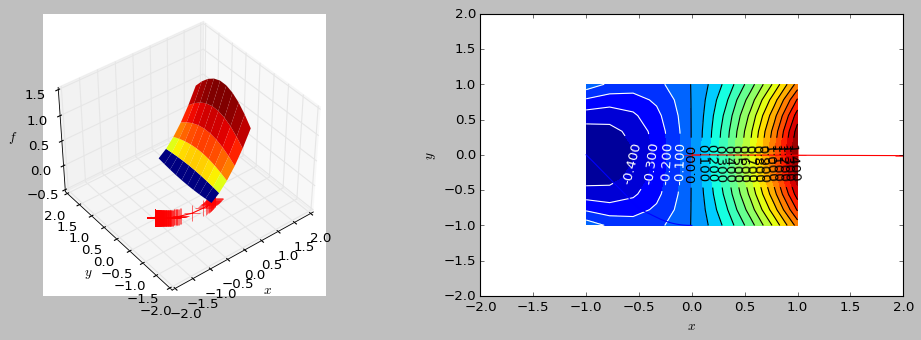

In [22]:
F = func.oscill()
x0 = np.array([0, -1])

list_xk, list_Fk, list_norm_gradJk, list_step = Gradient_Wolfe.fit(F, x0)

plot_step(F, list_xk)


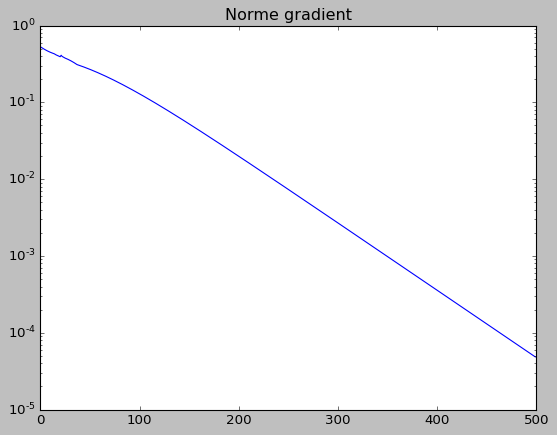

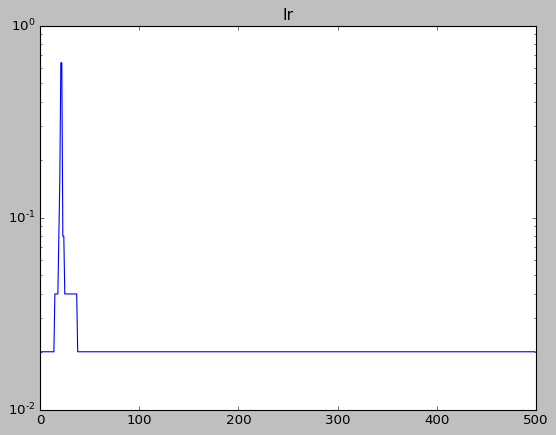

In [23]:
plt.title("Norme gradient")
plt.semilogy(list_norm_gradJk)
plt.show()
plt.title("lr")
plt.semilogy(list_step)
plt.show()


In [9]:
class BFGS():
	

	

	def get(self):
		return self.__find_direction(self.g).reshape(self.shape)

	def __find_direction(self, grad):
		if len(self.stock) == 0:
			return -grad
		else:
			r = np.copy(grad)
			l_alpha = []
			for (dx, dg, rho) in reversed(self.stock):
				alpha = rho*np.dot(dx, r)
				r = r-alpha*dg
				l_alpha.append(alpha)
			l_alpha = list(reversed(l_alpha))
			(dx, dg, rho) = self.stock[-1]
			gamma = np.dot(dx, dg)/np.dot(dg, dg)
			r = gamma*r
			for ((dx, dg, rho), alpha) in zip(self.stock, l_alpha):
				beta = rho*np.dot(dg, r)
				r = r+(alpha-beta)*dx
			return -r

class BFGS(object):
    def __init__(self, nb_stock_max: int = 8) -> None:
        self.nb_stock_max = nb_stock_max
        self.stock = []
        self.last_iter = []
        super().__init__()

    def pushjh(self, x, g):
		self.shape = x.shape
		x = x.reshape(-1)
		g = g.reshape(-1)
		self.g = np.copy(g)
		if self.last_it is not None:
			x_old, g_old = self.last_it
			curv = np.dot(x-x_old, g-g_old)
			if curv > 1.e-14:
				self.stock.append((np.copy(x-x_old), np.copy(g-g_old), 1./curv))
			else:					
				self.stock = []
			if len(self.stock) > self.nb_stock_max:
				self.stock.pop(0)
		self.last_it = (np.copy(x), np.copy(g))

    def push(self, x, grad):
        if len(self.last_iter) > 0:
            xk, gradFk = self.last_iter[-1]
            sk = x - xk
            yk = grad - gradFk  # yk = gk ?
            rhok = 1.0/np.dot(sk, yk)
            if rhok > 0:
                if len(self.stock) >= self.nb_stock_max:
                    self.stock.pop(0)
                    self.stock.append((sk, yk, rhok))
                else:
                    self.stock.append((sk, yk, rhok))
            else:
                print("warning")
                self.stock = []
        self.last_iter.append((x, grad))

    def get(self, grad):
        if len(self.stock) == 0:
            return -grad
        r = -grad
        alpha = []
        for i, (si, yi, rhoi) in enumerate(reversed(self.stock)):
            alpha.append(rhoi*np.dot(si, r))
            r = r - alpha[i]*yi
        sk, yk, rhok = self.stock[-1]
        r = r*(np.dot(sk, yk)/np.dot(yk, yk))
        beta = []
        for i, (si, yi, rhoi) in enumerate(self.stock):
            beta.append(rhoi*np.dot(yi, r))
            r = r + (alpha[i]-beta[i])*si
        return r


In [10]:
bfgs = BFGS()
def direction_lbfgs(F, x):
    gradF = F.grad(x)
    bfgs.push(x, gradF)
    norm_gradJk = np.linalg.norm(gradF)
    #Calcul de dk par LBFGS
    direction = -bfgs.get(gradF)
    return direction


In [11]:
F = rosenbrock()
x0 = np.array([0, -1])

BFGS_Wolf = Optimizer(direction_lbfgs, fixed_step)

list_xk, list_Fk, list_norm_gradJk, list_step = BFGS_Wolf.fit(F, x0)

plot_step(F, list_xk)


NameError: name 'rosenbrock' is not defined

In [ ]:
list_xk
